# Optimisation pour le Machine Learning
### Notebook expérimental — Descente de gradient et méthodes stochastiques

Ce notebook étudie et compare différentes méthodes d’optimisation :
- Gradient Descent (Batch)
- Stochastic Gradient Descent (SGD)
- Mini-batch Gradient Descent
- Adam

Les expériences sont réalisées sur le jeu de données YearPredictionMSD.


### CODE (Imports)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

np.random.seed(42)


## Étape 1 — Chargement et préparation des données


In [ ]:
# Charger le dataset en local
data_path = "YearPredictionMSD/YearPredictionMSD.txt"   
data = pd.read_csv(data_path, header=None)

print("Shape du dataset :", data.shape)
data.head()


Shape du dataset : (515345, 91)


,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,90
0,2001,49.94357,21.47114,73.07750,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,...,13.01620,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327
1,2001,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,...,5.66812,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061
2,2001,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,...,3.03800,26.05866,-50.92779,10.93792,-0.07568,43.20130,-115.00698,-0.05859,39.67068,-0.66345
3,2001,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,...,34.57337,-171.70734,-16.96705,-46.67617,-12.51516,82.58061,-72.08993,9.90558,199.62971,18.85382
4,2001,50.97020,42.20998,67.09964,8.46791,-15.85279,-16.81409,-12.48207,-9.37636,12.63699,...,9.92661,-55.95724,64.92712,-17.72522,-1.49237,-7.50035,51.76631,7.88713,55.66926,28.74903


Le dataset contient :
- La première colonne : la variable cible (année)
- Les colonnes suivantes : les caractéristiques audio


### CODE (Séparation X / y)

In [3]:
y = data.iloc[:, 0].values
X = data.iloc[:, 1:].values

print("X shape :", X.shape)
print("y shape :", y.shape)


X shape : (515345, 90)
y shape : (515345,)


### CODE (Train / Test split)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


### Standardisation

In [5]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


La standardisation est indispensable afin d'améliorer le conditionnement
du problème et la stabilité des algorithmes de descente de gradient.


## Étape 2 — Modélisation et fonctions mathématiques


### Fonction objectif

In [6]:
def objective(w, X, y, mu):
    n = X.shape[0]
    return (1 / n) * np.sum((X @ w - y) ** 2) + (mu / 2) * np.linalg.norm(w) ** 2


### Gradient

In [7]:
def gradient(w, X, y, mu):
    n = X.shape[0]
    return (2 / n) * X.T @ (X @ w - y) + mu * w


Nous considérons une régression linéaire régularisée de type Ridge.
Le gradient est calculé analytiquement.


## Étape 3 — Descente de gradient batch (GD)


### Gradient Descent

In [8]:
def gradient_descent(X, y, mu, alpha, n_iter):
    n, d = X.shape
    w = np.zeros(d)
    history = []

    for k in range(n_iter):
        grad = gradient(w, X, y, mu)
        w -= alpha * grad
        history.append(objective(w, X, y, mu))

    return w, history


### Exécution GD

In [9]:
mu = 1e-3
alpha_gd = 1e-2

X_small = X_train[:20000]
y_small = y_train[:20000]

w_gd, hist_gd = gradient_descent(
    X_small, y_small, mu, alpha_gd, n_iter=100
)


### Plot GD

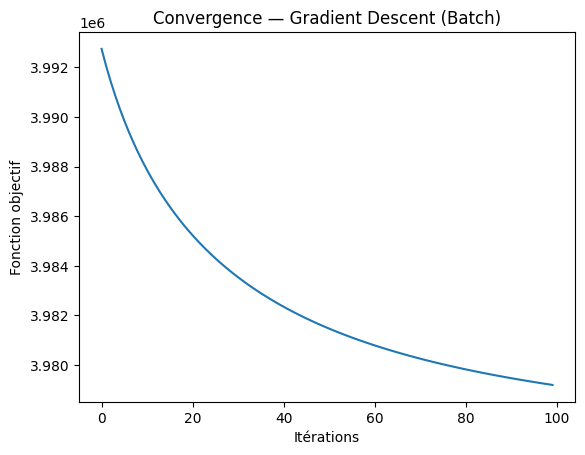

In [10]:
plt.plot(hist_gd)
plt.xlabel("Itérations")
plt.ylabel("Fonction objectif")
plt.title("Convergence — Gradient Descent (Batch)")
plt.show()


La descente de gradient batch présente une convergence régulière et stable.
La fonction objectif diminue progressivement à chaque itération, ce qui
confirme que le pas d’apprentissage choisi est approprié.


## Étape 4 — Stochastic Gradient Descent (SGD)


### SGD

In [11]:
def sgd(X, y, mu, alpha, n_iter):
    n, d = X.shape
    w = np.zeros(d)
    history = []

    for k in range(n_iter):
        i = np.random.randint(n)
        xi = X[i]
        yi = y[i]

        grad_i = 2 * xi * (xi @ w - yi) + mu * w
        w -= alpha * grad_i

        if k % 1000 == 0:
            history.append(objective(w, X, y, mu))

    return w, history


### Exécution SGD stabilisé

In [12]:
alpha_sgd = 1e-4

w_sgd, hist_sgd = sgd(
    X_train, y_train, mu=1e-3, alpha=alpha_sgd, n_iter=50000
)


### Comparaison GD vs SGD

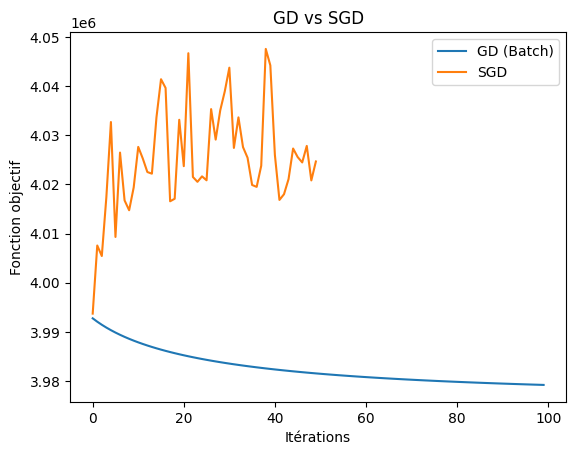

In [13]:
plt.plot(hist_gd, label="GD (Batch)")
plt.plot(hist_sgd, label="SGD")
plt.legend()
plt.xlabel("Itérations")
plt.ylabel("Fonction objectif")
plt.title("GD vs SGD")
plt.show()


La descente de gradient stochastique présente des oscillations importantes
dues au bruit dans l’estimation du gradient. Bien que le SGD soit plus rapide
par itération, il ne converge pas de manière monotone et oscille autour
d’une valeur moyenne de la fonction objectif.


## Étape 5 — Mini-batch Gradient Descent


### Mini-batch

In [14]:
def mini_batch_sgd(X, y, mu, alpha, batch_size, n_iter):
    n, d = X.shape
    w = np.zeros(d)
    history = []

    for k in range(n_iter):
        idx = np.random.choice(n, batch_size, replace=False)
        Xb = X[idx]
        yb = y[idx]

        grad = (2 / batch_size) * Xb.T @ (Xb @ w - yb) + mu * w
        w -= alpha * grad

        if k % 500 == 0:
            history.append(objective(w, X, y, mu))

    return w, history


### Exécution Mini-batch

In [15]:
w_mb, hist_mb = mini_batch_sgd(
    X_train, y_train,
    mu=1e-3,
    alpha=1e-3,
    batch_size=128,
    n_iter=20000
)


### Plot Mini-batch

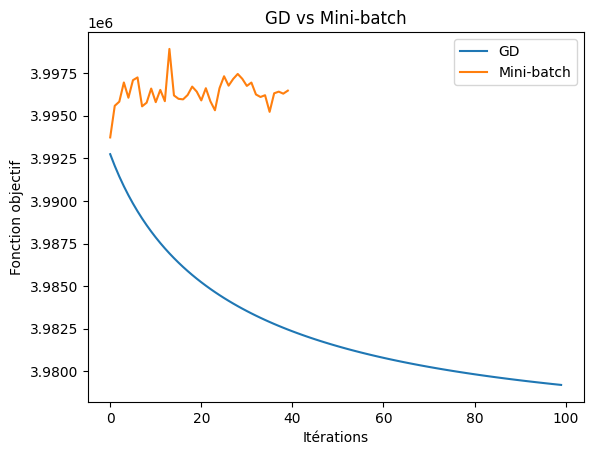

In [16]:
plt.plot(hist_gd, label="GD")
plt.plot(hist_mb, label="Mini-batch")
plt.legend()
plt.xlabel("Itérations")
plt.ylabel("Fonction objectif")
plt.title("GD vs Mini-batch")
plt.show()


### Interprétation — GD vs Mini-batch


On observe que :
- La descente de gradient batch (GD) présente une convergence régulière et monotone.
- La méthode mini-batch montre des oscillations autour d’une valeur moyenne de
  la fonction objectif.

Ces oscillations sont dues au bruit résiduel dans l’estimation du gradient,
puisque chaque mise à jour utilise seulement un sous-ensemble des données.


## Étape 6 — Adam


### Adam

In [17]:
def adam(X, y, mu, alpha, n_iter, beta1=0.9, beta2=0.999, eps=1e-8):
    n, d = X.shape
    w = np.zeros(d)
    m = np.zeros(d)
    v = np.zeros(d)
    history = []

    for k in range(1, n_iter + 1):
        i = np.random.randint(n)
        xi = X[i]
        yi = y[i]

        g = 2 * xi * (xi @ w - yi) + mu * w

        m = beta1 * m + (1 - beta1) * g
        v = beta2 * v + (1 - beta2) * (g ** 2)

        m_hat = m / (1 - beta1 ** k)
        v_hat = v / (1 - beta2 ** k)

        w -= alpha * m_hat / (np.sqrt(v_hat) + eps)

        if k % 1000 == 0:
            history.append(objective(w, X, y, mu))

    return w, history


### Exécution Adam

In [18]:
w_adam, hist_adam = adam(
    X_train, y_train, mu=1e-3, alpha=1e-3, n_iter=30000
)


### Comparaison finale

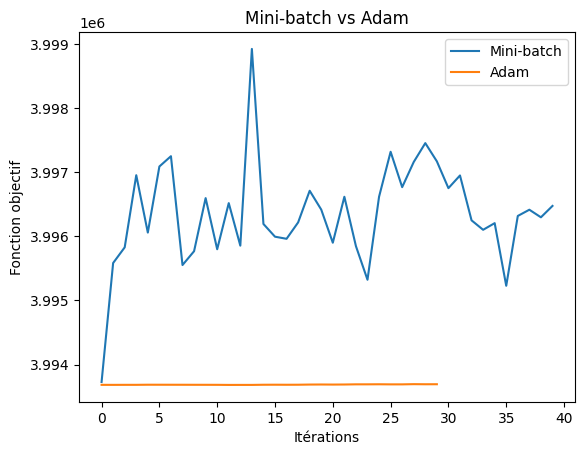

In [19]:
plt.plot(hist_mb, label="Mini-batch")
plt.plot(hist_adam, label="Adam")
plt.legend()
plt.xlabel("Itérations")
plt.ylabel("Fonction objectif")
plt.title("Mini-batch vs Adam")
plt.show()


###   Mini-batch vs Adam

On observe que :
- La méthode mini-batch présente des oscillations importantes de la fonction objectif.
- Adam converge très rapidement vers une valeur basse et reste extrêmement stable
  au cours des itérations.


### Analyse

Adam adapte automatiquement le pas d’apprentissage pour chaque paramètre
en utilisant des estimations des moments du gradient.

Cette adaptation permet :
- une convergence plus rapide,
- une réduction significative des oscillations,
- une meilleure robustesse face au bruit du gradient.


### Conclusion — Mini-batch vs Adam

Les résultats montrent clairement l’avantage des méthodes adaptatives.
Adam combine les bénéfices des méthodes stochastiques avec une stabilité
remarquable, ce qui explique son utilisation généralisée en pratique.


#  Parcimonie et Algorithmes Proximaux (L1)

On s’intéresse à la classification de documents sur le dataset Reuters RCV1,
caractérisé par une très grande dimension et des variables redondantes.

Objectifs :
- Comprendre l’intérêt géométrique de la régularisation L1
- Implémenter ISTA et FISTA
- Comparer leurs vitesses de convergence
- Étudier la sélection de variables via le paramètre λ


### a) Analyse géométrique : L1 vs L2

En haute dimension, la régularisation L1 est préférable à L2 pour l’interprétabilité.

- La boule L2 est sphérique : les solutions touchent rarement les axes.
- La boule L1 est un polytope avec des coins alignés sur les axes.
- Les minima sont souvent atteints sur les coins → coefficients exactement nuls.

Conclusion :
La régularisation L1 induit naturellement des solutions parcimonieuses,
ce qui est crucial pour la sélection de mots pertinents en classification de documents.


### Imports et chargement RCV1

In [39]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder


In [40]:
data_path = "rcv1_data/rcv1rcv2aminigoutte/EN/Index_EN-EN"

texts = []
labels = []

with open(data_path, "r", encoding="latin-1") as f:
    for i, line in enumerate(f):
        if i >= 3000:
            break
        parts = line.strip().split()
        labels.append(parts[0])              # ex: ECAT
        texts.append(" ".join(parts[1:]))    # pseudo-document


### Encodage binaire (ECAT vs reste)

In [41]:
y = np.array([1 if lab == "ECAT" else 0 for lab in labels])
print("Proportion classe positive :", y.mean())


Proportion classe positive : 0.685


### Données et dimensions

In [ ]:
X = rcv1.data          # matrice sparse (n × d)
Y = rcv1.target       # labels multilabel (n × C)

print("X shape :", X.shape)
print("Y shape :", Y.shape)


### Vectorisation TF-IDF (HAUTE DIMENSION)

In [42]:
vectorizer = TfidfVectorizer(
    max_features=20000,
    stop_words="english"
)

X = vectorizer.fit_transform(texts)

print("X shape :", X.shape)


X shape : (3000, 20000)


### Fonction objectif LASSO

In [43]:
def objective_lasso(w, X, y, lam):
    n = X.shape[0]
    return (1/n) * np.linalg.norm(X @ w - y)**2 + lam * np.linalg.norm(w, 1)


### Gradient de la partie lisse

In [47]:
def grad_f(w, X, y):
    n = X.shape[0]
    return (2/n) * X.T @ (X @ w - y)


### Opérateur proximal L1 (Soft-thresholding)


In [48]:
def soft_thresholding(v, tau):
    return np.sign(v) * np.maximum(np.abs(v) - tau, 0)


### ISTA

In [49]:
def ista(X, y, lam, alpha, n_iter):
    d = X.shape[1]
    w = np.zeros(d)
    history = []

    for k in range(n_iter):
        w = soft_thresholding(
            w - alpha * grad_f(w, X, y),
            alpha * lam
        )
        history.append(objective_lasso(w, X, y, lam))

    return w, history


### FISTA (accélération)

In [51]:
def fista(X, y, lam, alpha, n_iter):
    d = X.shape[1]
    w = np.zeros(d)
    z = w.copy()
    t = 1
    history = []

    for k in range(n_iter):
        w_old = w.copy()

        w = soft_thresholding(
            z - alpha * grad_f(z, X, y),
            alpha * lam
        )

        t_new = (1 + np.sqrt(1 + 4 * t**2)) / 2
        z = w + ((t - 1) / t_new) * (w - w_old)
        t = t_new

        history.append(objective_lasso(w, X, y, lam))

    return w, history


### Comparaison convergence

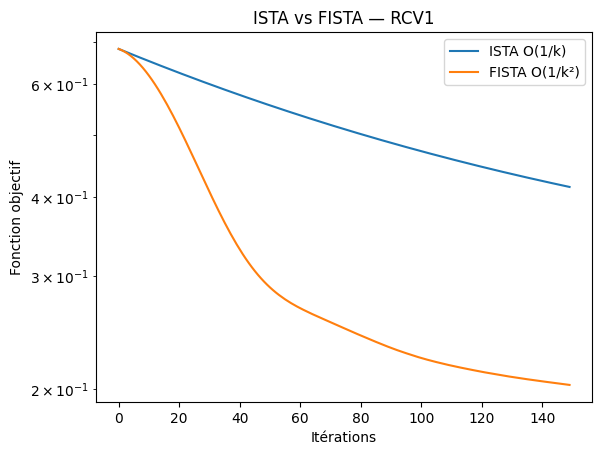

In [52]:
lam = 1e-3
alpha = 0.1
n_iter = 150

_, hist_ista = ista(X, y, lam, alpha, n_iter)
_, hist_fista = fista(X, y, lam, alpha, n_iter)

plt.plot(hist_ista, label="ISTA O(1/k)")
plt.plot(hist_fista, label="FISTA O(1/k²)")
plt.yscale("log")
plt.xlabel("Itérations")
plt.ylabel("Fonction objectif")
plt.legend()
plt.title("ISTA vs FISTA — RCV1")
plt.show()


### Sélection de variables et Effet de λ sur la parcimonie

In [54]:
lambdas = [1e-4, 1e-3, 1e-2, 1e-1]
nnz = []

for lam in lambdas:
    w, _ = ista(X, y, lam, alpha, 100)
    nnz.append(np.sum(w != 0))



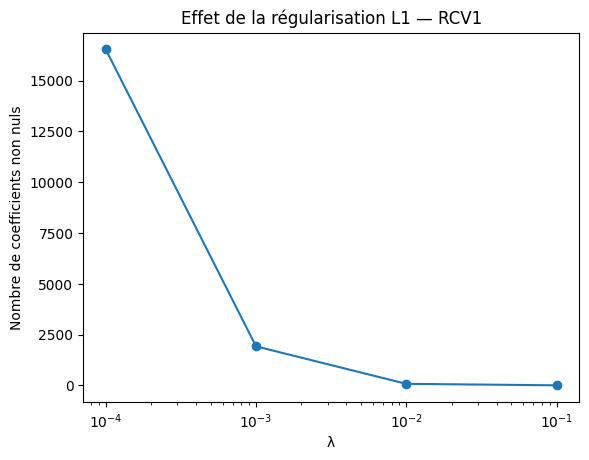

In [55]:
plt.plot(lambdas, nnz, marker="o")
plt.xscale("log")
plt.xlabel("λ")
plt.ylabel("Nombre de coefficients non nuls")
plt.title("Effet de la régularisation L1 — RCV1")
plt.show()
